# Multi layer perceptron implementation
 The first part will implement MLP  using numpy
 The second part will use pytorh implementation
 

In [3]:
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import model_selection

In [4]:


class MLP1():
    """
    dimensions: the list dimension in order
    input_dim: input dimension
    output_dim  output dimension
    activation : activation function for the hidden layers
    last_layer_activation : last activation function
    batch_size : make sure to have a sive of batch divisable by the shape of your dataset
    """
    def __init__(self,dimensions,activation='relu',last_layer_activation='sigmoid',batch_size=100,learning_rate=0.01, tol=1e-4,nb_iter=200) -> None:
        self.hidden_dim=dimensions[1:-1]
        self.nb_hidden_layers=len(dimensions)-2
        self.input_dim=dimensions[0]
        self.output_dim=dimensions[-1]
        self.dimensions=dimensions
        self.activation=activation
        self.tol=tol
        self.nb_iter=nb_iter
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.last_layer_activation=last_layer_activation
        self.weights=[]
        self.biases=[]
        self._init_weights()


    def _init_weights_(self,value):
        # initialize using  kaiming (for relu_activ)
        # used fan_in here 'fan_in' (default) or 'fan_out'.
        # Choosing 'fan_in' preserves the magnitude of the variance of the weights in the forward pass.
        # Choosing 'fan_out' preserves the magnitudes in the backwards pass.
        for i in range(len(self.dimensions)-1):
            sigma=(np.sqrt(value/self.dimensions[i]))
            self.weights.append(np.random.normal(0,sigma,(self.dimensions[i+1],self.dimensions[i])))



    def _init_weights(self):

        if(self.activation=='relu'):
            # initialization using kaiming
            value=2
            self._init_weights_(value)
        else:
            # initialisation using  xavier initialization
            value=1
            self._init_weights_(value)
        self.biases=[np.zeros((i,1)) for i in self.dimensions[1:]]


    def relu(self, x):
        return np.maximum(np.zeros(x.shape), x)
    def relu_derivate(self,x):
        return np.where(x > 0, 1, 0)
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    def sigmoid_derivative(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    def tanh(self,x):
        return np.tanh(x)
    def tanh_derivative(self,x):
        1 - np.tanh(x)**2
    def softmax(self,x):
        return np.exp(x)/np.sum(np.exp(x))


    def forward(self,X_batch):
        X_i=X_batch
        z_is=[]
        a_is=[X_i]
        for i in range(len(self.weights)-1):
            z_i=np.dot(self.weights[i],X_i) + self.biases[i]
            z_is.append(z_i)
            if (self.activation=='relu' ):
                X_i=self.relu(z_i)
                a_is.append(X_i)
            if (self.activation=='tanh'):
                X_i=self.tanh(z_i)
                a_is.append(X_i)

        z_i=np.dot(self.weights[-1],X_i) + self.biases[-1]
        z_is.append(z_i)
        if (self.last_layer_activation=='sigmoid'):
            a_i=self.sigmoid(z_i)
        if (self.last_layer_activation=='softmax'):
            a_i=self.softmax(z_i)
        a_is.append(a_i)

        return a_is,z_is




    def backward(self,ais,zs,y):
        " Backward propagation"
        prediction=ais[-1]
        y=y.reshape(prediction.shape)
        deltas=[]
        delta=(prediction-y)

        for i in range(len(self.weights)-1,0,-1):
            if self.activation=='relu':
                deltas=[delta]+deltas
                delta=np.dot(self.weights[i].T,delta)* self.relu_derivate(zs[i-1])
            if self.activation=='tanh':
                deltas=[delta]+deltas
                delta=np.dot(self.weights[i].T,delta)* self.tanh_derivative(zs[i-1])
            if self.activation=='sigmoid':
                deltas=[delta]+deltas
                delta=np.dot(self.weights[i].T,delta)* self.sigmoid_derivative(zs[i-1])
        deltas=[delta]+deltas

        for i in range(0,len(self.weights)):
            self.weights[i]-=self.learning_rate*np.dot(deltas[i],ais[i].T)/ self.batch_size
            self.biases[i]-=self.learning_rate*np.mean(deltas[i],axis=1).reshape(self.biases[i].shape)

        return



    def accuracy(self,y_pred,y_true):
      if(self.last_layer_activation=='sigmoid'):
        y_pred=np.round(y_pred)
        acc=np.mean(y_pred==y_true)
        #print(y_pred)
        #print(y_true)
      if(self.last_layer_activation=='softmax'):
        y_pred=np.argmax(y_pred,axis=1)
        acc=np.mean(y_pred==y_true)
      return acc
    def __loss(self,y_pred,y_true):
      if(self.last_layer_activation=='sigmoid'):
        loss=-np.mean(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
      if(self.last_layer_activation=='softmax'):
        loss=-np.mean(y_true*np.log(y_pred))

      return loss

    def train(self,X,y,X_val,y_val,nb_epochs=10):
        n_samples=X.shape[1]
        nb_pass=n_samples//self.batch_size
        #print("nb_pass: {}".format(nb_pass))
        batch_size=self.batch_size
        predicts=[]
        train_losses=[]
        train_accs=[]
        val_losses=[]
        val_accs=[]
        for i in range(nb_epochs):
          shuffle = np.random.permutation(n_samples)
          X_s=X.T[shuffle]
          y_s=y.T[shuffle]
          train_loss=0
          train_acc=0

          for i in range(0,nb_pass):
            X_batch=X_s[i*batch_size:(i+1)*batch_size].T
            y_batch=y_s[i*batch_size:(i+1)*batch_size]
            #print(X_batch.shape)
            #print(y_batch.shape)
            a_is,z_is=self.forward(X_batch)

            self.backward(a_is,z_is,y_batch)
            prediction=a_is[-1]
            #print(np.mean(np.round(prediction)==y_batch))
            train_loss+=self.__loss(prediction,y_batch)
            train_acc+=self.accuracy(prediction,y_batch)

          train_losses.append(train_loss/nb_pass)
          train_accs.append(train_acc/nb_pass)

          a_is,z_is=self.forward(X_val)
          prediction=a_is[-1]
          val_losses.append(self.__loss(prediction,y_val))
          val_accs.append(self.accuracy(prediction,y_val))


        return train_losses,train_accs,val_losses,val_accs





In [5]:
X, y = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)

print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))
print(set(y))

# X is (nbExamples, nbDim)
# y is (nbExamples,)

# --- Standardize data
X -= np.mean(X, axis=0, keepdims=True)
X /= (np.std(X, axis=0, keepdims=True) + 1e-16)

# --- Split between training set and test set
X_train, X_test, hat_y_train, hat_y_test = model_selection.train_test_split(X, y, test_size=0.2)

# --- Convert to proper shape: (nbExamples, nbDim) -> (nbDim, nbExamples)
X_train = X_train.T
X_test = X_test.T

# --- Convert to proper shape: (nbExamples,) -> (1, nbExamples)
#hat_y_train = hat_y_train.reshape(1, len(hat_y_train))
#hat_y_test = hat_y_test.reshape(1, len(hat_y_test))

n_in = X_train.shape[0]
n_out = 1

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("hat_y_train.shape: {}".format(hat_y_train.shape))
print("hat_y_test.shape: {}".format(hat_y_test.shape))
print("n_in: {} n_out: {}".format(n_in, n_out))


X.shape: (1000, 2)
y.shape: (1000,)
{0, 1}
X_train.shape: (2, 800)
X_test.shape: (2, 200)
hat_y_train.shape: (800,)
hat_y_test.shape: (200,)
n_in: 2 n_out: 1


In [6]:
dimensions=[X.shape[1],10,12,1]
mlp=MLP1(dimensions)
train_losses,train_accs,val_losses,val_accs=mlp.train(X_train,hat_y_train, X_test, hat_y_test,nb_epochs=500)

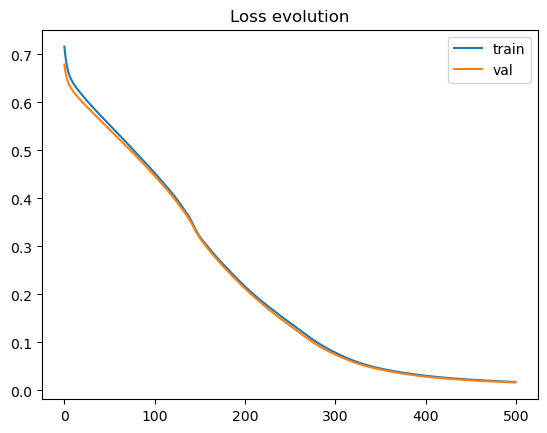

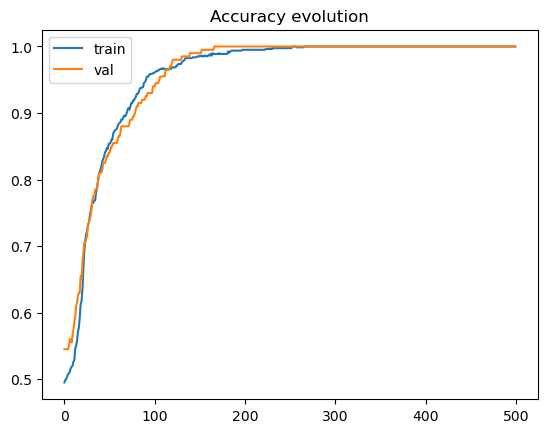

In [7]:
plt.figure()
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.title('Loss evolution')
plt.show()

plt.figure()
plt.plot(train_accs,label='train')
plt.plot(val_accs,label='val')
plt.legend()
plt.title('Accuracy evolution')
plt.show()